In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from metpy.plots import USCOUNTIES

In [3]:
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

In [4]:
def plot_fake_climate_change(station, agg_type='mean', filename=None, n=10):
    """Plot Temperature (average, min and max) and Precipitation for a given station as a function of time.
    Aggregation can be specified with agg_type param."""

    path = 'weather/minnesota_daily'
    file = os.path.join(path,station+'.csv')
    df = pd.read_csv(file, header=None)
    df.columns = ['date', 'tavg', 'tmin', 'tmax', 'prcp',]
    df['year'] = df['date'].apply(lambda x: x[:4])
    agg_df = df[['tavg', 'tmin', 'tmax', 'prcp', 'year']].groupby('year').agg(agg_type)

    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16,8))
    axes[0].set_title(f'Weather parameters for station {station}. Aggregation type: {agg_type}', fontsize=20)
    columns = ['tavg', 'tmin', 'tmax', 'prcp']
    labels = ['T average [°C]', 'T min [°C]', 'T max [°C]', 'Precipitation [mm]']

    for ax,col,label in zip(axes, columns, labels):
        ax.plot(agg_df.index, agg_df[col])
        ax.set_ylabel(label)
        ax.xaxis.set_major_locator(plt.MaxNLocator(n))
    
    if filename is not None:
        plt.savefig(filename)
        
def plot_station_data(station, stepsize=10, filename=None):
    """Plot Temperature (average, min and max) and Precipitation for a given station as a function of time"""


    path = 'weather/minnesota_daily'
    file = os.path.join(path,station+'.csv')
    df = pd.read_csv(file, header=None)
    df.columns = ['date', 'tavg', 'tmin', 'tmax', 'prcp',]

    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16,8))
    axes[0].set_title(f'Weather parameters for station {station}', fontsize=20)
    columns = ['tavg', 'tmin', 'tmax', 'prcp']
    labels = ['T average [°C]', 'T min [°C]', 'T max [°C]', 'Precipitation [mm]']

    for ax,col,label in zip(axes, columns, labels):
        ax.plot(df.date[::stepsize], df[col][::stepsize])
        ax.set_ylabel(label)
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
        
    if filename is not None:
        plt.savefig(filename)
        
def plot_map(show_stations=True, show_capitals=False, filename=None):
    '''Plot the map of Minnesota
    '''
    # western and eastern longitudes and southern and northen latitudes
    lon_w, lon_e, lat_s, lat_n = -98, -89, 43, 50
    extent = [lon_w, lon_e, lat_s, lat_n]

    #set up the figure
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_w, lon_e, step=2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_s, lat_n, step=2), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #add features to the map
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor="tomato")
    ax.add_feature(cfeature.STATES, linewidth=0.6, edgecolor='black', zorder=999)
    ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.15, edgecolor='black', facecolor='white')
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', zorder=999)
    #ax.add_feature(cartopy.feature.RIVERS, edgecolor=cartopy.feature.COLORS['water'], zorder=999)

    
    if show_stations:
        stations = pd.read_csv('weather/minnesota_daily_updated.csv')
        ax.scatter(stations.Longitude, stations.Latitude, s=stations.data_points/100, c='red', transform=ccrs.PlateCarree(), zorder=1000, label='Stations')
    if show_capitals:
        capitals = pd.read_csv('agri/minnesota_county_location.csv')
        ax.scatter(capitals.county_longitude, capitals.county_latitude, marker='^', s=10, c='blue', transform=ccrs.PlateCarree(), zorder=1000, label='Capitals')

    ax.legend()

    if filename is not None:
        plt.savefig(filename)

In [5]:
capitals = pd.read_csv('agri/minnesota_county_location.csv')
stations = pd.read_csv('weather/Minnesota Station location list.csv')

station_list, data_points, first_sample, last_sample = [], [], [], []

PATH = 'weather/minnesota_daily'
minnesota_daily = [os.path.join(PATH, f) for f in os.listdir(PATH)]

for file in minnesota_daily:
    df = pd.read_csv(file, header=None)
    df.columns = ['date', 'tavg', 'tmin', 'tmax', 'prcp',]
    station_list.append(file[-9:-4])
    data_points.append(len(df))
    first_sample.append(df.date.values[0])
    last_sample.append(df.date.values[-1])
    
temp_df = pd.DataFrame(zip(station_list, data_points, first_sample, last_sample))
temp_df.columns = ['Code', 'data_points', 'first_sample', 'last_sample']

df_cd = pd.merge(stations, temp_df, how='inner', on='Code')
df_cd.to_csv('weather/minnesota_daily_updated.csv', index=False)
df_cd.sort_values('data_points', ascending=False, inplace=True)
df_cd.reset_index(inplace=True, drop=True)
df_cd

,Code,Latitude,Longitude,data_points,first_sample,last_sample
0,72755,47.5000,-94.9333,39235,1896-02-01,2022-06-17
1,72644,43.9000,-92.5000,39016,1893-01-18,2022-06-17
2,72747,48.5667,-93.4000,33789,1906-07-01,2022-06-17
3,72658,44.8667,-93.0500,30758,1938-04-09,2022-06-24
4,72655,45.5466,-94.0599,30678,1904-09-01,2022-06-17
...,...,...,...,...,...,...
92,P6529,48.8500,-95.7000,55,2022-04-24,2022-06-17
93,UYB6K,48.0667,-96.1833,55,2022-04-24,2022-06-17
94,9NRIJ,45.1426,-93.2127,55,2022-04-24,2022-06-17
95,Z7ZOG,44.5483,-95.0804,55,2022-04-24,2022-06-17


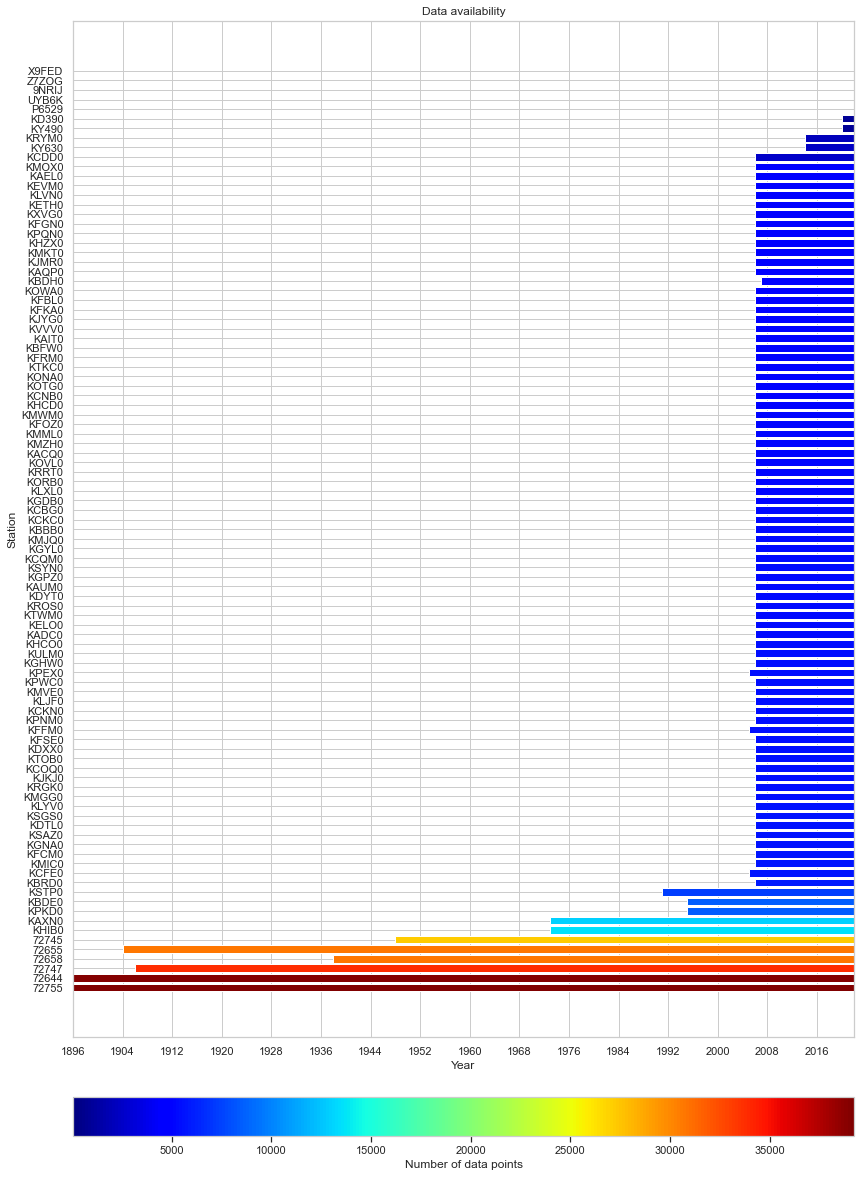

In [6]:
df_cd['start_year'] = df_cd['first_sample'].apply(lambda x: int(x[:4]))
df_cd['end_year'] = df_cd['last_sample'].apply(lambda x: int(x[:4]))
df_cd['dur'] = df_cd.end_year - df_cd.start_year

norm = mpl.colors.Normalize(vmin=df_cd.data_points.min(), vmax=df_cd.data_points.max())
cmap = cm.jet
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rgbas = []
for i in df_cd.data_points.values.tolist():
    rgbas.append(m.to_rgba(i))
    
fig, ax = plt.subplots(1, figsize=(14,22))
ax.barh(df_cd.Code, df_cd.dur, left=df_cd.start_year, color=rgbas)
ax.set_xlim(1896,2022)
ax.set_xticks([1896+i for i in range(0,126,8)])
ax.set_xlabel('Year')
ax.set_ylabel('Station')
ax.set_title('Data availability')
plt.colorbar(m, orientation='horizontal', pad=0.05, fraction=0.1).set_label('Number of data points')
plt.savefig('data_availability.png')

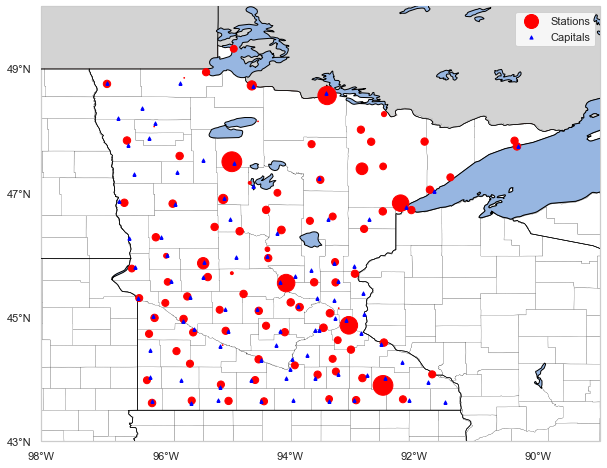

In [7]:
plot_map(True,True)

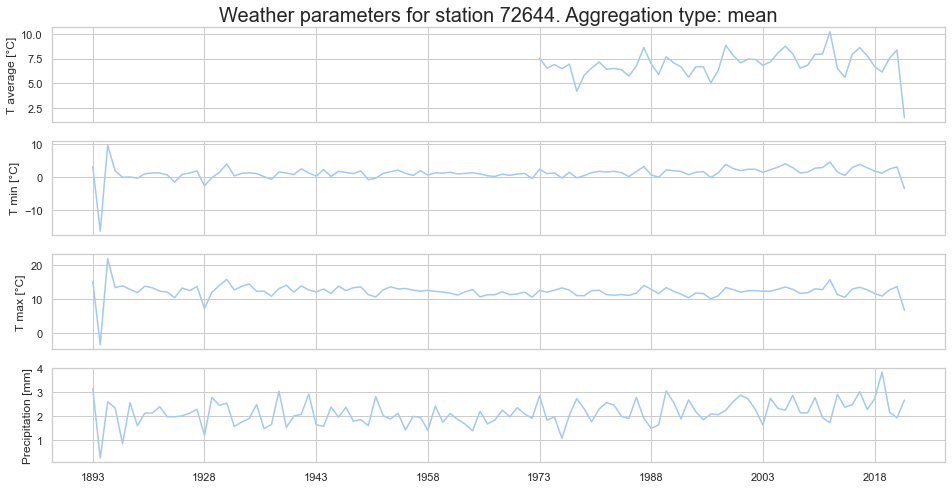

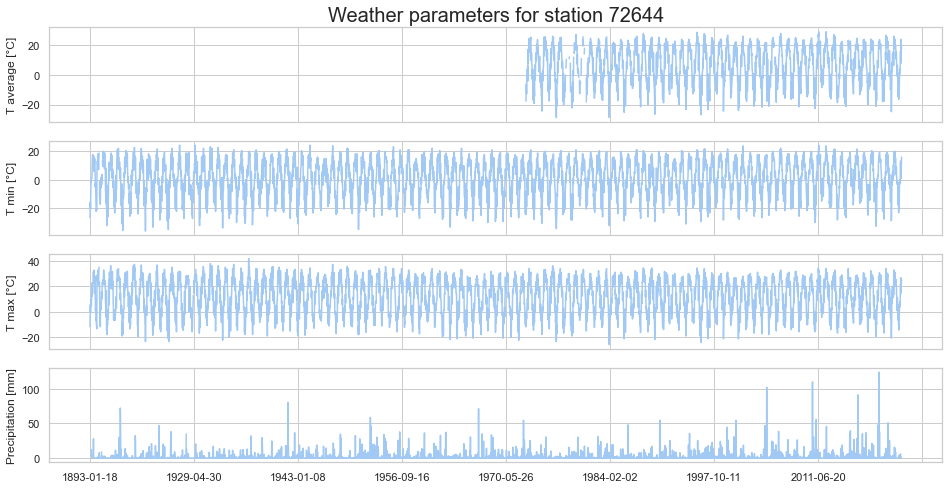

In [45]:
STATION = '72644'
plot_fake_climate_change(STATION)
plot_station_data(STATION)

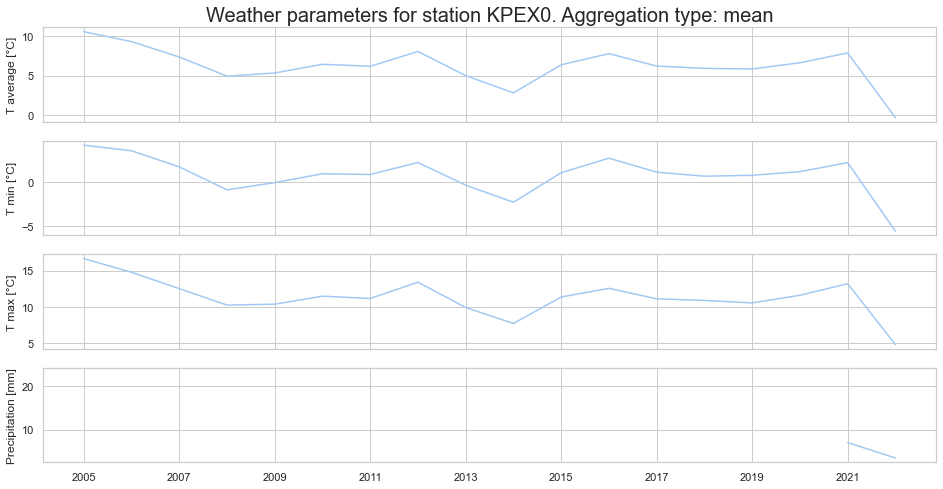

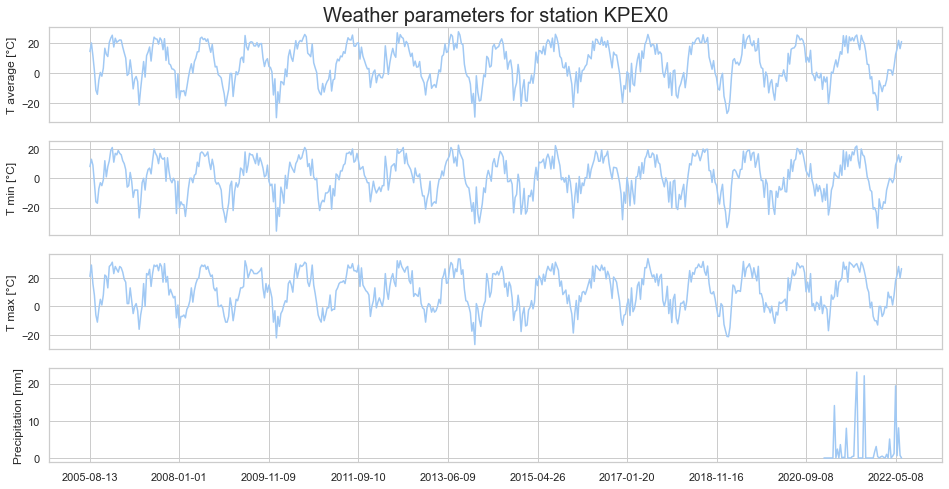

In [47]:
STATION = 'KPEX0'
plot_fake_climate_change(STATION)
plot_station_data(STATION)